## Loading/preparing data and evaluating performance

This intermediate assignment teaches you how to prepare your data for training and testing and how to evaluate the performance of any biometric system in a verification and identification scenario

## Structuring your data

While some Python packages provide readers for  training/validation/testing data for certain classification problems, other data need to be entered using hand-tailored procedures. 

The simplest way to structure your data is to have all data for a single individual/object in a separate directory. 
The following code block (SimpleDatasetLoader) reads this data and structures it as (data, label) tuples.

In [1]:
# import the necessary packages
import numpy as np
import cv2
import pathlib as Path
import cv2
import numpy as np
import argparse
from matplotlib import pyplot as plt
import pathlib as Path
import fprmodules.enhancement as fe
import statistics

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

%matplotlib inline 

## Function Definitions

In [13]:
def SimpleDatasetLoader(imagePaths):
    # initialize the list of features and labels
    data = []
    labels = []
    img_names = []

    # loop over the input images
    for imagePath in imagePaths:
        image = cv2.imread(str(imagePath), cv2.IMREAD_GRAYSCALE)
        height, width = image.shape[:2]
        label = imagePath.name.split("_")[0]
        img_name = imagePath.name

        data.append(image.flatten())
        labels.append(label)
        img_names.append(img_name)
    # return a tuple of the data and labels
    return (np.array(data), np.array(labels), np.array(img_names), height, width)

def labels_to_class(labels):
    class_labels = np.empty(len(labels))
    for i in range(len(labels)):
        class_labels[i] = labels[i].split("_")[0]
    # encode the labels as integers
    le = LabelEncoder()
    class_labels = le.fit_transform(class_labels)
    return class_labels

def matching_ORB(img1,img2):    
    MAX_FEATURES = 500
    GOOD_MATCH_PERCENT = 0.25
    # Initiate ORB detector
    orb = cv2.ORB_create(MAX_FEATURES)
    # find the keypoints and descriptors with SIFT
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING2, crossCheck=True)
    matches = bf.match(des1,des2)
    matches.sort(key=lambda x: x.distance, reverse=False)
    
    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]

    return kp1, kp2, matches

def plot_matches(img1,kp1,img2,kp2,matches):
    # Draw top 10 matches
    imMatches = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10], None)
    plt.imshow(imMatches),plt.show()

def mid_match_dist(matches):    
    if len(matches)==0:
        return float('nan')
    d = []    
    for match in matches:
        d.append(match.distance)   
    mid = statistics.median(d)    
    return mid

def enhancement(img1,img2): #img_2
    # frequency and orientation selective filtering/enhancement
    img_e_1, mask1, orientim1, freqim1 = fe.image_enhance(img1);  
    img_e_2, mask2, orientim2, freqim2 = fe.image_enhance(img2);     

    # normalize the floating point values to a uint8 range
    img_e_u_1 = cv2.normalize(img_e_1, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=0 )
    img_e_u_2 = cv2.normalize(img_e_2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=0 )   
    
    return img_e_u_1, img_e_u_2

In [3]:
from pathlib import Path

#datasetPath = Path("/path/to/dataset")
datasetPath = Path("C:/Users/Sumi/Desktop/NOTES SEM2/Biometrics System Concepts/Project/ASSIGN 1/AssignmentFPR1/fprdata/DB2_B/")
# recursively grab the list of images (in this particular case ending on .tif)
print("[INFO] loading images from DB2_B")
imagePaths = datasetPath.rglob("*.tif")

[INFO] loading images from DB2_B


Load the images and labels 

In [4]:
# load the dataset from disk and reshape the data matrix (images flattened)
(data, labels, img_names , height, width) = SimpleDatasetLoader(imagePaths)
labels = labels_to_class(labels)
# show some information on memory consumption of the images
print("[INFO] features matrix: {:.1f}MB".format(data.nbytes / (1024 * 1000.0)))


[INFO] features matrix: 12.9MB


Two Random Images
Image names:  102_1.tif 102_2.tif


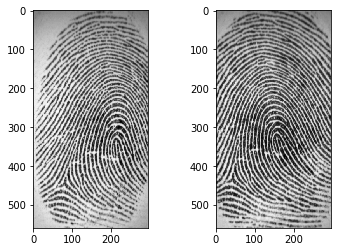

In [8]:
# Plot an image from the data
def plot_2imgs(im1,im2):
    plt.subplot(1,2,1)
    plt.imshow(im1, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(im2, cmap='gray')
    plt.show()

# Display two finger prints of same person
print("Two Random Images")
print("Image names: ", img1_label, img2_label)
img1 = np.reshape(data[np.where(labels == 1)[0][0]], (height, width))
img2 = np.reshape(data[np.where(labels == 1)[0][1]], (height, width))
plot_2imgs(img1,img2)
img1_label = img_names[np.where(labels == 1)[0][0]]
img2_label = img_names[np.where(labels == 1)[0][1]]



Matching Points between 2 original images


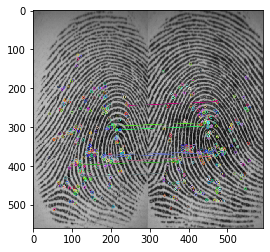

In [12]:
print("Matching KeyPoints between 2 original images")
kp1, kp2,matches = matching_ORB(img1,img2)
plot_matches(img1,kp1,img2,kp2,matches)


Matching KeyPoints between 2 Enhanced images


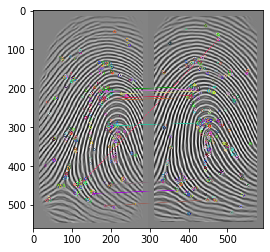

In [14]:
img_1_e,img_2_e =  enhancement(img1,img2)
kp1, kp2, matches = matching_ORB(img_1_e,img_2_e)
print("Matching KeyPoints between 2 Enhanced images")
plot_matches(img_1_e,kp1,img_2_e,kp2,matches)

### Applying Homography

In [15]:
def apply_homography(img1,kp1,kp2,matches):
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

    # Use homography
    height, width = img1.shape[:2]
    im1_homo = cv2.warpPerspective(img1, M, (width, height))

    return im1_homo

Homography applied to Original Images


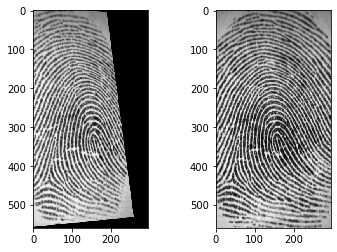

In [17]:
new_img_1 =  apply_homography(img1,kp1,kp2,matches)
print("Homography applied to Original Images")
plot_2imgs(new_img_1,img2)

Homography applied to Enhanced Images


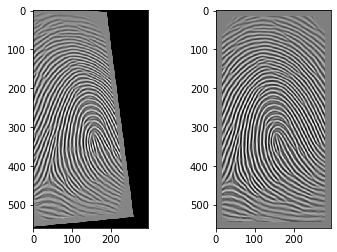

In [19]:
new_img_1_e = apply_homography(img_1_e,kp1,kp2,matches)
print("Homography applied to Enhanced Images")
plot_2imgs(new_img_1_e,img_2_e)

Matching KeyPoints between 2 Enhanced images after Homography


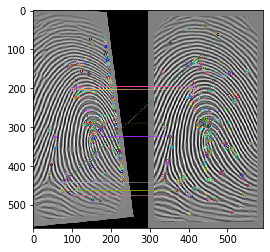

In [20]:
kp1, kp2, matches = matching_ORB(new_img_1_e,img_2_e)
print("Matching KeyPoints between 2 Enhanced images after Homography")
plot_matches(new_img_1_e,kp1,img_2_e,kp2,matches)

## Loading Enhanced Data from Disk

In [21]:
# Enhanced images for DB2_B
enh_datasetPath = Path('C:/Users/Sumi/Desktop/NOTES SEM2/Biometrics System Concepts/Project/ASSIGN 1/AssignmentFPR1/fprdata/enh_DB2_B/')
(data_enh, labels_enh, img_names_enh, height, width) = SimpleDatasetLoader(enh_datasetPath.rglob("*.tif"))


#### Matching Function

In [25]:
def check_matching(data, labels):   
    mat_size = data.shape[0]
    matching = np.zeros((mat_size,mat_size))
    for i in range(mat_size):
        for j in range(mat_size):
            if(labels[i] == labels[j]):
                matching[i][j] = 1
                
    return matching.flatten() 
true_match = check_matching(data, labels)

### Loading Original, Enhanced and Homography Distance Matrices Stored earlier

In [27]:
outPath = './fprdata/Output Files/' #To save the distance matrices obtained
y_dist_orig = np.load(outPath+'Orig_distMat_DB_2.npy')
y_dist_enh = np.load(outPath+'Enhanced_distMat_DB_2.npy')
y_dist_homo = np.load(outPath+'Homography_distMat_DB_2.npy')

# (score = 1 - distance)

y_dist_orig = cv2.normalize(y_dist_orig, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
y_score_orig = 1-y_dist_orig
y_dist_enh = cv2.normalize(y_dist_enh, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
y_score_enh = 1-y_dist_enh
y_dist_homo = cv2.normalize(y_dist_homo, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
y_score_homo = 1-y_dist_homo



In [34]:
print(len(y_score_orig),len(y_score_enh),len(y_score_homo))

6400 6400 6400


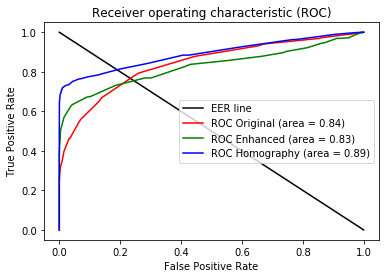

In [37]:
fpr_orig, tpr_orig, th_orig = roc_curve(true_match, y_score_orig, pos_label=1)
roc_auc_orig = auc(fpr_orig, tpr_orig)

fpr_enh, tpr_enh, th_enh = roc_curve(true_match, y_score_enh, pos_label=1)
roc_auc_enh = auc(fpr_enh, tpr_enh)

fpr_homo, tpr_homo, th_homo = roc_curve(true_match, y_score_homo, pos_label=1)
roc_auc_homo = auc(fpr_homo, tpr_homo)

# plot the roc curve for the model
plt.plot([1, 0],[0, 1], 'k-',label='EER line')
plt.plot(fpr_orig, tpr_orig, 'r',label='ROC Original (area = %0.2f)' %roc_auc_orig)
plt.plot(fpr_enh, tpr_enh, 'g',label='ROC Enhanced (area = %0.2f)' %roc_auc_enh)
plt.plot(fpr_homo, tpr_homo, 'b',label='ROC Homography (area = %0.2f)' %roc_auc_homo)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc='right')
plt.show()

# fnr = 1 - tpr
# eer_threshold = (np.absolute(fnr[1]- fpr[1]))
# print('EER = ', eer_threshold)
# print('fpr =', fpr[1])
# print('tpr =', tpr[1])

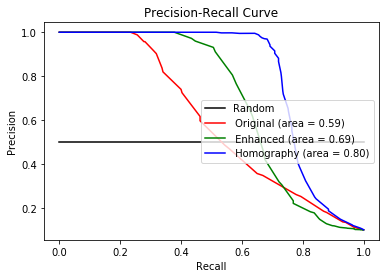

In [39]:
precision_orig, recall_orig, th_orig = precision_recall_curve(true_match, y_score_orig)
auc_orig = auc(recall_orig, precision_orig)
ap_orig = average_precision_score(true_match, y_score_orig)

precision_enh, recall_enh, th_enh = precision_recall_curve(true_match, y_score_enh)
auc_enh = auc(recall_enh, precision_enh)
ap_enh = average_precision_score(true_match, y_score_enh)

precision_homo, recall_homo, th_homo = precision_recall_curve(true_match, y_score_homo)
auc_homo = auc(recall_homo, precision_homo)
ap_homo = average_precision_score(true_match, y_score_homo)

# plot the precision-recall for the model
plt.plot([0, 1], [0.5, 0.5], 'k-',label='Random')
plt.plot(recall_orig, precision_orig, 'r',label=' Original (area = %0.2f)' %auc_orig)
plt.plot(recall_enh, precision_enh, 'g',label=' Enhanced (area = %0.2f)' %auc_enh)
plt.plot(recall_homo, precision_homo, 'b',label=' Homography (area = %0.2f)' %auc_homo)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='right')
plt.show()

If need be, split in train and test. However, for the validation of biometric systems we will NOT make such a split as we will use ALL the data to calculate the performance metrics.

In [43]:
from sklearn.model_selection import train_test_split

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)
(trainX_enh, testX_enh, trainY_enh, testY_enh) = train_test_split(data_enh, labels_enh, test_size=0.25, random_state=42)
train_s = trainX.shape[0]
test_s = testX.shape[0]
train_enh_s = trainX_enh.shape[0]
test_enh_s = testX_enh.shape[0]
# print(train_s,test_s,train_enh_s,test_enh_s)
print(height, width)

560 296


In [46]:

# dist_matrix_orig = np.empty((test_s,train_s))
# dist_matrix_enh = np.empty((test_s,train_s))
dist_matrix_homo = np.empty((test_s,train_s))
outPath = './fprdata/Output Files/' #To save the distance matrices obtained

for i in range(test_s):
    img1_orig = np.reshape(testX[i], (height, width))
    img1_enh = np.reshape(testX_enh[i], (height, width))
    
    for j in range(train_s):
        img2_orig = np.reshape(trainX[i], (height, width))
        img2_enh = np.reshape(trainX_enh[i], (height, width))
    
        kp1, kp2, matches = matching_ORB(img1_orig,img2_orig)
        enh_kp1, enh_kp2, enh_matches = matching_ORB(img1_enh,img2_enh)
        
        # Applying homography to the enhanced images
        enh_img1_homo =  apply_homography(img1_enh,kp1,kp2,matches)
        kp1_aft_homo, kp2_aft_homo, matches_aft_homo = matching_ORB(enh_img1_homo,img2_enh)
        
        dist_matrix_homo[i][j] = mid_match_dist(matches)
#         enh_dist_matrix[i][j] = find_distance(enh_matches)
#         homo_dist_matrix[i][j] = find_distance(matches_aft_homo)

dist_matrix_f = dist_matrix_homo.flatten()


In [49]:
outfile = outPath+'/TrainTest_distMat_DB_2'
np.save(outfile,dist_matrix_f)

In [52]:
y_dist_orig_enh = np.load(outPath+'TrainTest_distMat_DB_2.npy')
y_dist_orig_enh_norm = cv2.normalize(y_dist_orig_enh, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
y_score_orig_enh_norm = 1-y_dist_orig_enh_norm
y_score_orig_enh_norm.shape

(1200, 1)

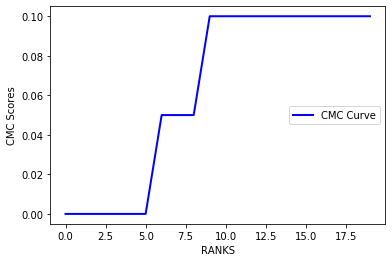

In [70]:
cmc_scores,ranks = get_cmcScores(y_score_orig, trainY, testY)
# cmc_scores = [cmc_scores_orig,cmc_scores_new]
# ranks = [ranks_orig,ranks_new]
plot_cmc(cmc_scores,ranks)

#### Reference: Github
- Calculation: https://github.com/yoavalon/CMC-Curve/blob/master/CMC_scores.py 
- Plotting: LinShanify/CMC https://github.com/LinShanify/CMC


In [69]:
# from CMC import CMC
def get_cmcScores(y_score_normal, y_train, y_test):
    cmcScores = []
    ranks = np.zeros(y_test.shape[0])

    for i in range(0,ranks.shape[0]):
        true_label = y_test[i]
        predictions = y_train[np.argsort(y_score_normal[i])]

        if true_label in predictions :
            firstOccurance = np.argmax(predictions ==  true_label)

            for j in range(firstOccurance,ranks.shape[0]) :            
                ranks[j] +=1
        
        cmcScores.append([float(i)/float(ranks.shape[0]) for i in ranks][0])
    ranks = np.arange(y_test.shape[0])
    return cmcScores,ranks
def plot_cmc(cmc_scores,ranks):
    c = ['r','g','b']

#     for i in range(len(ranks)):
#         plt.plot(ranks[i], cmc_scores[i], color=c[i], linewidth=2, label=f"CMC Curve{i+1}")
    plt.plot(ranks, cmc_scores, color='b', linewidth=2, label="CMC Curve")
    plt.xlabel("RANKS")
    plt.ylabel("CMC Scores")
    plt.legend(loc='right')
    plt.show()

## Authentication/Verification validation


[1]: <https://link.springer.com/book/10.1007/978-0-387-77326-1> ('Introduction to Biometrics' by AK Jain et al)
[2]: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> (How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python)

In an authentication scenario, one has a binary classification problem: is it the claimed identity or not. 
The performance of these systems is expressed as [follows][1] (section 1.4.1.1). 

* Genuine and impostor scores are calculated for the available data. From these scores genuine and impostor score distributions are generated and plotted as: 
![Image](ScoreDistributions.png)
* False Match Rates (FMR) and False Rejections Rates (FRR) are calculated as the cumulative (impostor and genuine, resp.) probability for every match score threshold value. 
* The ROC ([Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) curve ![ROC](ROCfig.png) is generated that plots the True Match Rate (or in this graph the FNMR = FRR (=1-TMR)) vs the FMR for different decision threshold values. Note: in this graph the axes have been swapped compared to the typical ROC presentation. 
* The overall performance (over all threshold settings) can be expressed through:
    * the Area Under the Curve (AUC) (with TMR((y-axis) vs FMR (x-axis))
    ![AUC](AUC.png)
    * the Equal Error Rate (EER), which is the point on the ROC-curve where FAR equals FRR. A lower EER value indicates better performance. ![EER](EER.png)

In a general binary classification setting, one also often presents Precision-Recall curves. How and when to use ROC or PRC is discussed [here][2]. A more general discussion of these measures is provided [here](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c). 
* Scikit-Learn provides routines for calculating these curves and numbers as demonstrated in the code listed below from the [link][2] above. 

Just for demo purposes: generate classification data and apply a kNN classifier: 

In [71]:
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from matplotlib import pyplot
%matplotlib inline

# generate 2 class dataset
X, y = make_classification(n_samples=1000, n_classes=2, weights=[1,1], random_state=1)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2)

# fit a model
model = KNeighborsClassifier(n_neighbors=3)
model.fit(trainX, trainy)

# predict probabilities
probs = model.predict_proba(testX)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = model.predict(testX)

Calculate the scores

In [72]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(testy, probs)

# calculate F1 score
f1 = f1_score(testy, yhat)

# calculate precision-recall AUC
auc = auc(recall, precision)

# calculate average precision score
ap = average_precision_score(testy, probs)

Print and plot the scores

f1=0.836 auc=0.892 ap=0.840


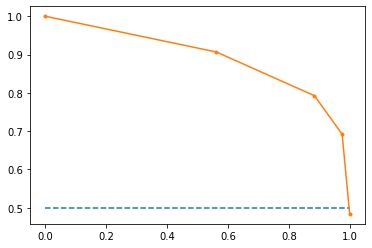

In [73]:
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()

* Alternatively, you can use the package Bob (and more specifically its performance metric routines [bob.measure](https://www.idiap.ch/software/bob/docs/bob/bob.measure/master/index.html#)). BE CAREFUL however and follow the [installation instructions](https://www.idiap.ch/software/bob/docs/bob/docs/stable/bob/doc/install.html), otherwise you might end up with a broken environment. If you have a working Python conda environment, create another one (possibly by cloning the original one) before installing this package.  

Using these packages, you can then: 
1. plot (on the same plot) the genuine and impostor distributions
2. plot the ROC curve
3. report the AUC and EER

With these plots and numbers, you can start comparing different biometric systems (same biometric with different implementation, or different biometrics) in an authentication/verification scenario. 


## Identification Validation 

In an identification scenario one has a 1-to-many or multi-class classification problem. The performance of such a system is typically measured by the Cumulative Match Characteristic (CMC) curve. This curve plots the experimental probability that a correct identification is returned within the top-x (x=1, ..., N) ranked matching scores. 
![CMC](CMC.jpg)

[Bolle et al.](https://ieeexplore.ieee.org/document/1544394) show that:
> the CMC is also related to the FAR and FRR of a 1:1 matcher, i.e., the matcher that is used to rank the candidates by sorting the scores. This has as a consequence that when a 1:1 matcher is used for identification, that is, for sorting match scores from high to low, the CMC does not offer any additional information beyond the FAR and FRR curves. The CMC is just another way of displaying the data and can be computed from the FAR and FRR.

This paper is not mandatory but those interested can have a look at it.

CMC curves can easily be generated once you have the ranked matching scores for every test face. Again the [bob.measure](https://www.idiap.ch/software/bob/docs/bob/bob.measure/master/index.html) routines will help you along the way. 

Text(0, 0.5, 'Probability of Recognition (%)')

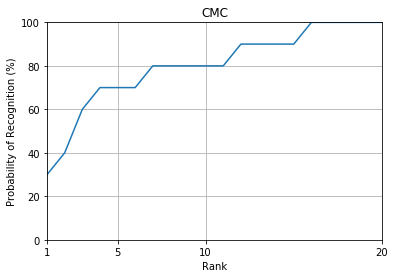

In [23]:
import numpy
import bob.measure
from matplotlib import pyplot
%matplotlib inline

numpy.random.seed(42)

cmc_scores = []
for probe in range(10):
  positives = numpy.random.normal(1, 1, 1)
  negatives = numpy.random.normal(0, 1, 19)
  cmc_scores.append((negatives, positives))

bob.measure.plot.cmc(cmc_scores, logx=False)
pyplot.grid(True)
pyplot.title('CMC')
pyplot.xlabel('Rank')
pyplot.xticks([1,5,10,20])
pyplot.xlim([1,20])
pyplot.ylim([0,100])
pyplot.ylabel('Probability of Recognition (%)')